    id                                           comments       subreddits
0    0  Honestly, Buffalo is the correct answer. I rem...           hockey
1    1  Ah yes way could have been :( remember when he...              nba
2    2  https://youtu.be/6xxbBR8iSZ0?t=40m49s\n\nIf yo...  leagueoflegends
3    3  He wouldn't have been a bad signing if we woul...           soccer
4    4  Easy. You use the piss and dry technique. Let ...            funny
5    5  The joke is on YOU!\n\nI've only seen it twice...            funny
6    6  His role in MI3 is one of the best villians I'...           movies
7    7  Akagi is still Alpha as fuck and Sugawara is s...            anime
8    8  I think that they had each other's detonator. ...           movies
9    9  Right! He was a disruptor tank! Pull the dps o...        Overwatch
10  10  The flying the Eagles to Mordor thing is incre...           movies
11  11  "Oh man I can't wait to vote."\n\n*opens link*...            anime
12  12  omg i was thinkin

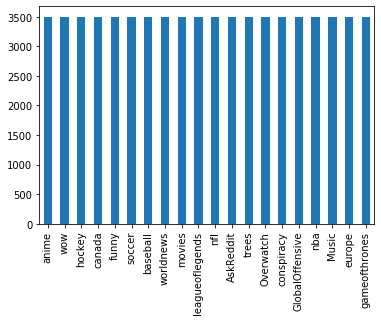

In [157]:
# based on tutorial from https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup


df = pd.read_csv('reddit-comment-classification-comp-551/reddit_train.csv')
df = df[pd.notnull(df['comments'])]
print(df.head(20))
print(df['comments'].apply(lambda x: len(x.split(' '))).sum())



df.subreddits.value_counts().plot(kind='bar');


The classes are balanced, but the text needs cleaning. Here's some cleaning (we should customize **TODO: we should make something to remove links... that is words starting with `http://` at least, should be ignored**):

In [158]:
delimiters = re.compile('[/(){}\[\]\|@,;]')
ignored_symbols = re.compile('[^0-9a-z #+_]')
# nltk.download('stopwords')
stopwords = set(stopwords.words('english'))


def print_plot(index):
    example = df[df.index == index][['comments', 'subreddits']].values[0]
    if len(example) > 0:
        print(example[0])
        print('subreddit:', example[1])


def clean_text(text):
    """
        text: a string (one comment)
        return: modified string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = delimiters.sub(' ', text) # replace delimiters symbols by space in text
    text = ignored_symbols.sub('', text) # delete symbols which are in ignored_symbols from text
    text = ' '.join(word for word in text.split() if word not in stopwords) # delete stopwords from text
    return text
    
df['comments'] = df['comments'].apply(clean_text)


Now to lemmatize the corpus.  This might not help in the short term, but will be useful to play with. 


In [159]:
from nltk.tokenize import word_tokenize

from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()

def lemmatize_sentence(sen):
    """ lemmatizes every word in space separated sentence sen""" 
    token_list = word_tokenize(sen)
    lemma_sen = []
    for w in token_list:
        lemma_sen.append(stemmer.stem(w))
    return " ".join(lemma_sen)

df['comments'] = df['comments'].apply(lambda x: lemmatize_sentence(x))

# print_plot(1234)
print(df.head(10))

   id                                           comments       subreddits
0   0  honest buffalo correct answ rememb peopl somew...           hockey
1   1  ah ye way could rememb draft thought gon na gr...              nba
2   2  https youtub 6xxbbr8isz0t40m49sif didnt find a...  leagueoflegends
3   3  wouldnt bad sign wouldnt paid 18m euro right p...           soccer
4   4  easy us piss dry techn let drop let dry rins r...            funny
5   5                                  jok you seen twic            funny
6   6  rol mi3 on best vil iv seen movy genuin felt l...           movies
7   7  akag stil alph fuck sugawar suff definit two f...            anime
8   8  think oth deton wouldnt prov jok right blew bo...           movies
9   9  right disrupt tank pul dps frey pick get point...        Overwatch


We could set the train test split here, or we could do some more processing

In [5]:
# X_train, X_test, y_train, y_test = train_test_split(df.comments, df.subreddits, test_size=0.3, random_state = 12)

In [160]:
values_array = np.unique(df.subreddits.values)

Defining a function to get **a list of words in the entire corpus of comments** (that is, `tokens`), and also **a list unique words** (that is `types`).

In [161]:
import itertools

tokens_list = df['comments'].apply(lambda x: word_tokenize(x)).values

tokens = np.array(list(itertools.chain.from_iterable(tokens_list)))

types, type_counts = np.unique(tokens, return_counts=True)

print("number of tokens",len(tokens))
print("number of types",len(types))

number of tokens 1601210
number of types 75440


Some words are more common than others.  We might want to do something with this. But for now it's just useful to have the information.  I'll make an uncommon-word list. We can remove them just like we did the stopwords. We'll do this later, with scikitlearn's CountVectorizer.

In [54]:
common_words = types[type_counts > 20]
len(common_words)

5379

In [55]:
# def downsize_vocab(text):
#     text = ' '.join(word for word in text.split() if word in common_words) # keep only common words
#     return text
    
# df['comments'] = df['comments'].apply(downsize_vocab)

In [56]:
# tokens_list = df['comments'].apply(lambda x: word_tokenize(x)).values

# tokens = np.array(list(itertools.chain.from_iterable(tokens_list)))

# types, type_counts = np.unique(tokens, return_counts=True)

# print("number of tokens",len(tokens))
# print("number of types",len(types))

number of tokens 1448186
number of types 5379


In [162]:
X_train, X_test, y_train, y_test = train_test_split(df.comments, df.subreddits, test_size=0.3, random_state = 12)

In [241]:
ID_list = X_test.index.tolist()

In [222]:
cv = CountVectorizer()
X_tf = cv.fit_transform(df.comments)

In [61]:
#from sklearn.feature_extraction.text import TfidfTransformer
#tfidf = TfidfTransformer()
#X_tfidf = tfidf.fit_transform(X_tf)

In [62]:
# X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.subreddits, test_size=0.3, random_state = 12)

## Running sklearn classifier model(s)

In [220]:
from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report

from sklearn.naive_bayes import BernoulliNB
bernoulli_nb = Pipeline([
                         ('ct_vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf', BernoulliNB()),
                        ])

from sklearn.linear_model import SGDClassifier
sgd = Pipeline([
                 ('ct_vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                       alpha=1e-3, random_state=27,
                                       max_iter=5, tol=None)),
                ])


def paramsearch(modelpipeline):
    '''
    modelpipeline: sklearn.pipeline.Pipeline object 
    does gridsearch on the given pipeline on test split and prints classification report
    '''
    from sklearn.model_selection import GridSearchCV
    parameters = {
        'ct_vect__ngram_range': [(1,1),(1, 2)],
        'ct_vect__max_features': [1000,5000],
#         'tfidf__use_idf': (True, False),
#         'clf__alpha': (1e-4, 1e-5),
    }

    gridsearch = GridSearchCV(modelpipeline, parameters, cv=5, iid=False, n_jobs=-1)
    gridsearch = gridsearch.fit(X_train, y_train)
    y_pred = gridsearch.predict(X_test)
#     print(gridsearch)
    print(gridsearch.best_params_)
    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred, target_names=values_array))

def runmodel(modelpipeline):
    ''' 
    modelpipeline: sklearn.pipeline.Pipeline object 
    runs the given pipeline on test split and prints classification report
    '''
    modelpipeline.fit(X_train, y_train)
    y_pred = modelpipeline.predict(X_test)
    print(modelpipeline)
    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred,target_names=values_array))

paramsearch(bernoulli_nb)

#runmodel(sgd)

{'ct_vect__max_features': 5000, 'ct_vect__ngram_range': (1, 1)}
accuracy 0.4512857142857143
                 precision    recall  f1-score   support

      AskReddit       0.28      0.17      0.21      1039
GlobalOffensive       0.47      0.56      0.51      1028
          Music       0.67      0.31      0.43      1011
      Overwatch       0.78      0.52      0.62      1085
          anime       0.55      0.44      0.49      1067
       baseball       0.45      0.55      0.50      1091
         canada       0.45      0.35      0.40      1012
     conspiracy       0.43      0.31      0.36      1019
         europe       0.55      0.40      0.46      1084
          funny       0.13      0.52      0.20      1053
  gameofthrones       0.90      0.52      0.66      1050
         hockey       0.51      0.51      0.51      1013
leagueoflegends       0.67      0.50      0.57      1013
         movies       0.59      0.50      0.54      1054
            nba       0.54      0.57      0.56      

In [189]:
dense = np.random.binomial(n=3, p=0.1, size=(3, 5))
print(dense)
print(np.transpose(dense))

[[0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]]
[[0 0 0]
 [0 0 0]
 [0 0 1]
 [0 1 0]
 [0 0 0]]


In [190]:
from scipy import sparse
sparse = sparse.csr_matrix(dense)

In [192]:
product = np.dot(2*sparse,np.transpose(sparse))

In [193]:
product

<3x3 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [194]:
print(product.toarray())

[[0 0 0]
 [0 2 0]
 [0 0 2]]


In [215]:
np.transpose(sparse).shape[1]

3